## Crossmatching GAIA Observation to Anything!

In [167]:
from astroquery.gaia import Gaia
from astroquery.mast import Observations
from astroquery.vizier import Vizier
from astropy.coordinates import SkyCoord
import astropy.units as u

# Step 1: Get Coordinates from GAIA DR3
gaia_id = '513671461473684352'

# Query GAIA DR3 for the source ID
job = Gaia.launch_job(f"SELECT * FROM gaiadr3.gaia_source WHERE source_id = {gaia_id}")
gaia_results = job.get_results()
if len(gaia_results) == 0:
    raise ValueError("GAIA source ID not found.")

ra = gaia_results['ra'][0]
dec = gaia_results['dec'][0]

print(ra, dec)

# Create SkyCoord object
coords = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')

# Step 2: Cross-match with Kepler and TESS catalogs, and other surveys
# 2a. Search in Kepler catalog
kepler_obs = Observations.query_criteria(coordinates=coords, radius=0.0001*u.deg, project='Kepler')

# 2b. Search in TESS catalog
tess_obs = Observations.query_criteria(coordinates=coords, radius=0.0001*u.deg, project='TESS')

# 2c. Search in Vizier for other photometric surveys
vizier = Vizier(columns=['*'])
vizier_results = vizier.query_region(coords, radius=0.0001*u.deg)

# Print results
print("GAIA Coordinates (RA, Dec):", ra, dec)
print("\nKepler Results:")
print(kepler_obs)

print("\nTESS Results:")
print(tess_obs)

print("\nOther Photometric Surveys Results (Vizier):")
for result in vizier_results:
    print(result)

36.674118427080344 62.35611398492885


GAIA Coordinates (RA, Dec): 36.674118427080344 62.35611398492885

Kepler Results:
intentType obs_collection provenance_name instrument_name project filters ... mtFlag srcDen obsid objID objID1 distance
---------- -------------- --------------- --------------- ------- ------- ... ------ ------ ----- ----- ------ --------

TESS Results:
intentType obs_collection provenance_name instrument_name project ... srcDen   obsid     objID     objID1  distance
---------- -------------- --------------- --------------- ------- ... ------ --------- --------- --------- --------
   science           TESS            SPOC      Photometer    TESS ...    nan  27620106  70823225  70823225      0.0
   science           TESS            SPOC      Photometer    TESS ...    nan 106583802 198023899 198023899      0.0
   science           HLSP             QLP      Photometer    TESS ...    nan  38581148  82522750  82522750      0.0
   science           HLSP            TICA      Photometer    TESS ...    nan 100582

## IRSA lightcurve

In [2]:
!pip install ztfquery

In [ ]:
from ztfquery import lightcurve
import matplotlib.pyplot as plt

# Coordinates for querying ZTF data (replace with your actual values)
ra = 36.674118
dec = 64.356114

# Query ZTF
radius_arcsec = 4  # search radius in arcseconds
lc_query = lightcurve.LCQuery.from_position(ra, dec, radius_arcsec, bandname="g")
lc_data = lc_query.data

In [ ]:
lc_query.show()

In [92]:
# import numpy as np

# # Fix the error by handling negative yerr (magnitude errors)
# lc_data['magerr'] = np.abs(lc_data['magerr'])  # Take absolute value
# # Alternatively, to exclude negative errors:
# # lc_data['magerr'] = np.where(lc_data['magerr'] < 0, np.nan, lc_data['magerr'])

In [72]:
lc_data_backup = lc_data

In [239]:
unique_oids = lc_data['oid'].unique()

# Print the unique oids
for oid in unique_oids:
    print(oid)

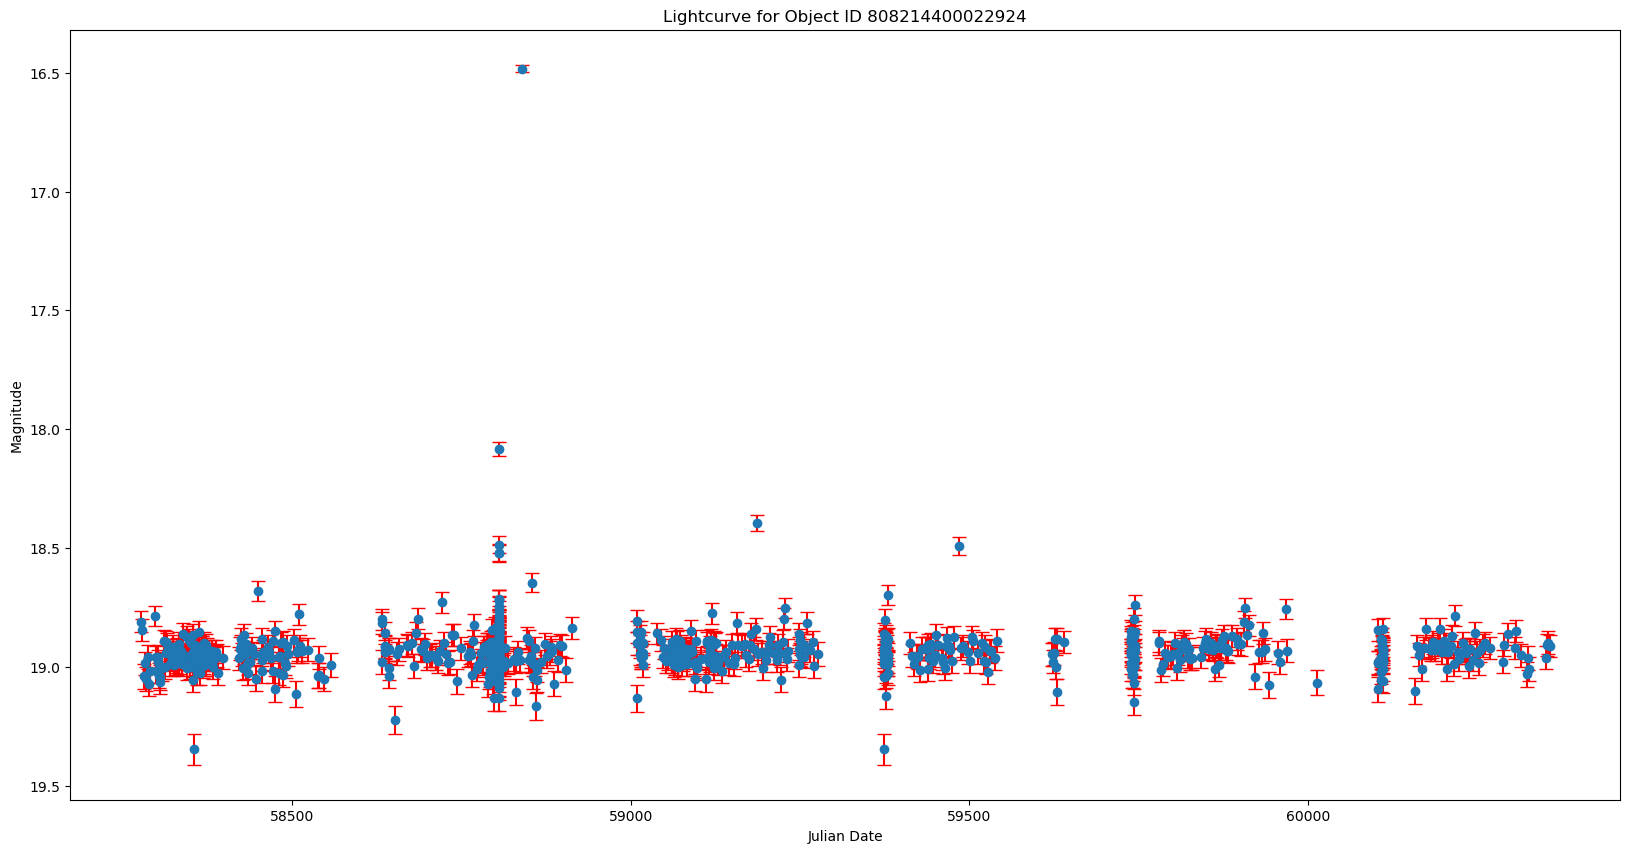

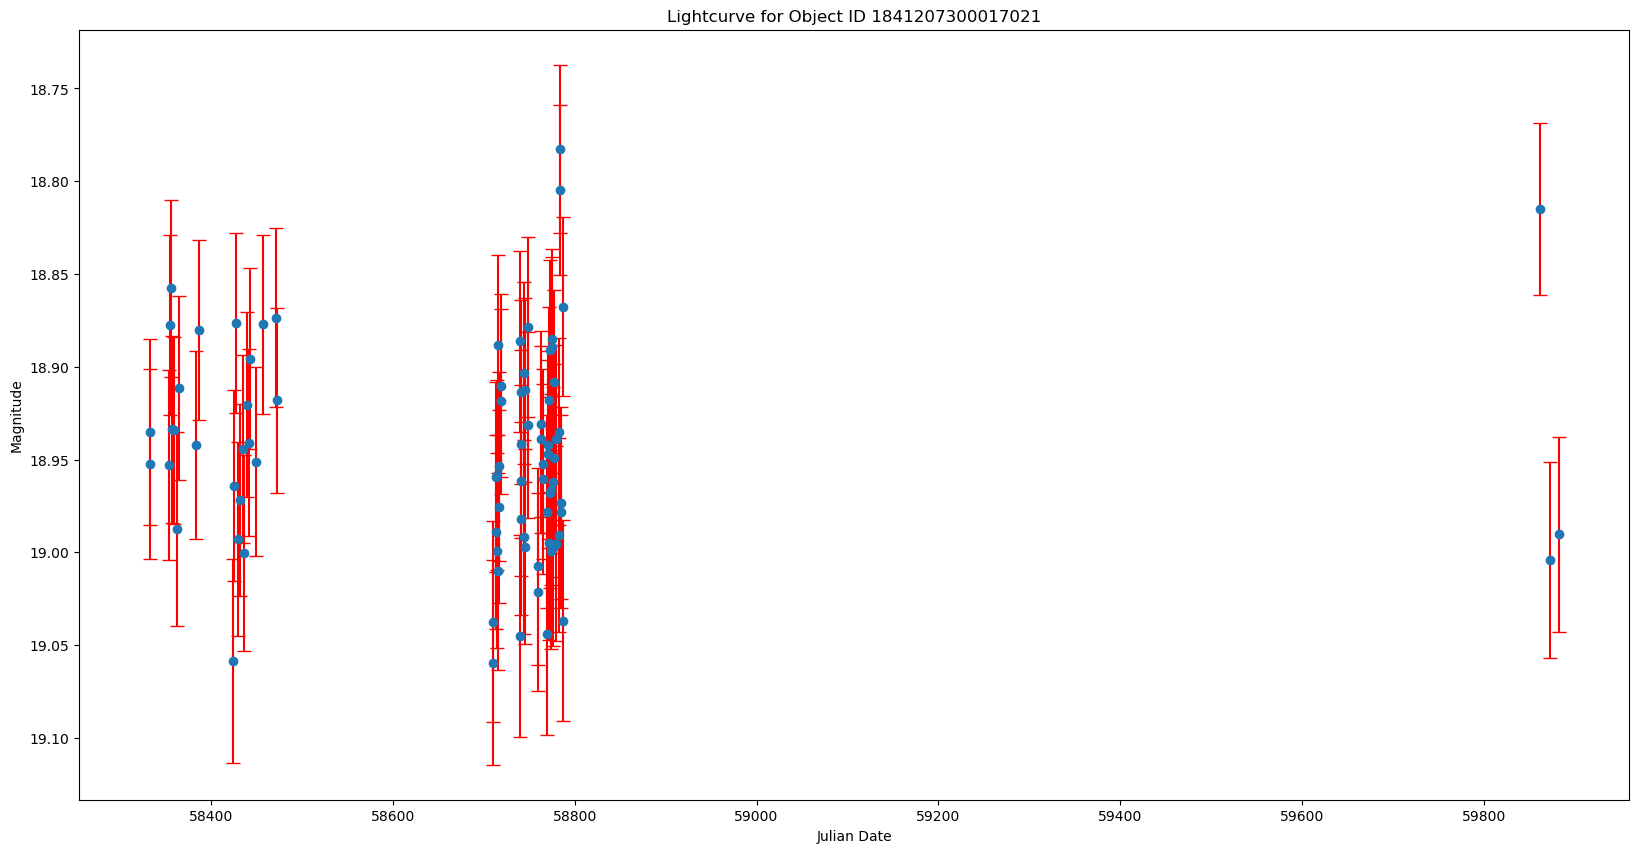

In [227]:
# Check if data is available
if not lc_data.empty:
    # Group data by 'oid'
    grouped = lc_data.groupby('oid')
    
    # Plot light curves for each star
    for oid, group in grouped:
        time = group['mjd']
        magnitude = group['mag']
        mag_err = group['magerr']
        
        plt.figure(figsize=(20, 10))
        plt.errorbar(time, magnitude, yerr=mag_err, fmt='o', ls='None', ecolor='red', capsize=5)
        plt.xlabel('Julian Date')
        plt.ylabel('Magnitude')
        plt.title(f'Lightcurve for Object ID {oid}')
        plt.gca().invert_yaxis()  # Magnitude scale is inverted
        plt.show()
else:
    print(f"No lightcurve data found for the given coordinates in ZTF.")

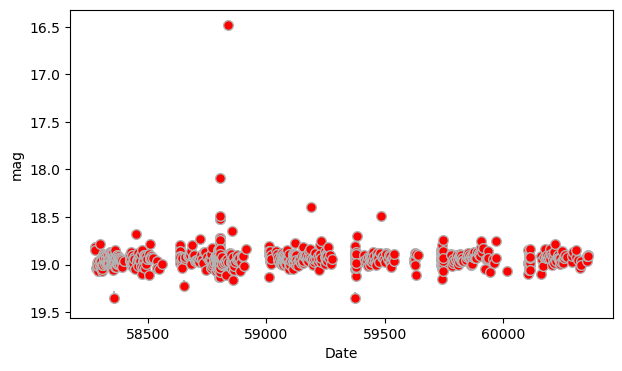

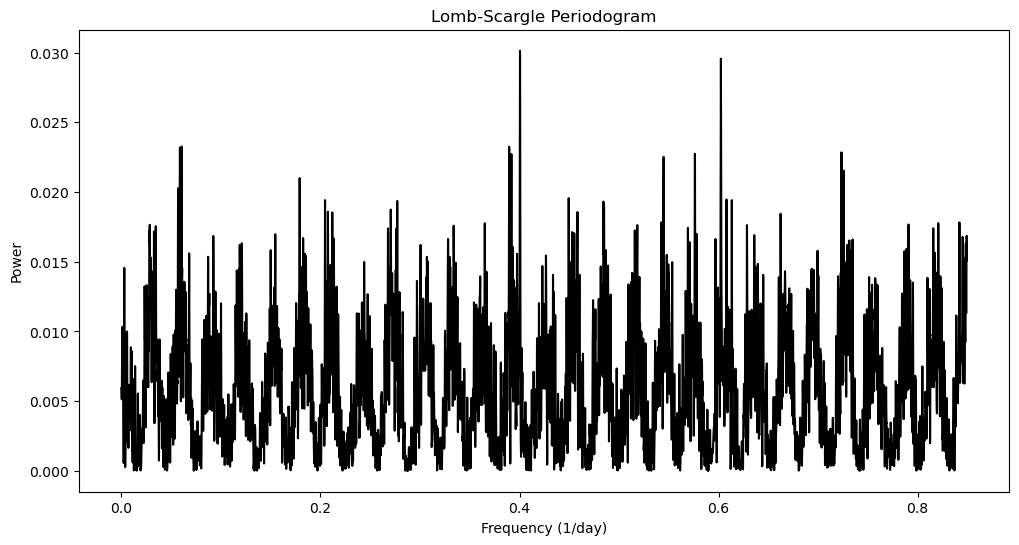

Best period: 2.49698467106684 days


In [233]:
from ztfquery import lightcurve
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle
import numpy as np

# Assume lc_data is already loaded from the previous query

# Replace this with the specific 'oid' you identified
specific_oid = 808214400022924

# Filter the data for the specific 'oid'
specific_data = lc_data[lc_data['oid'] == specific_oid]

# Check if data is available for the specific 'oid'
if not specific_data.empty:
    # Extract time (in JD) and magnitude for the specific 'oid'
    time = specific_data['mjd']
    magnitude = specific_data['mag']
    mag_err = specific_data['magerr']
    
    # Plot the light curve
    plt.figure(figsize=(7, 4))
    plt.errorbar(time, magnitude, yerr=mag_err, marker="o", mfc="red", mec="0.7", ms=7, ecolor="0.7", ls="None", zorder=4)
    plt.xlabel('Date')
    plt.ylabel('mag')
    # plt.title(f'Lightcurve for Object ID {specific_oid}')
    plt.gca().invert_yaxis()  # Magnitude scale is inverted
    plt.show()
    
    # Calculate the periodogram
    frequency, power = LombScargle(time, magnitude).autopower()

    # Plot the periodogram
    plt.figure(figsize=(12, 6))
    plt.plot(frequency, power, 'k-')
    plt.xlabel('Frequency (1/day)')
    plt.ylabel('Power')
    plt.title('Lomb-Scargle Periodogram')
    plt.show()

    # Identify the best period
    best_frequency = frequency[np.argmax(power)]
    best_period = 1 / best_frequency
    print(f'Best period: {best_period} days')
else:
    print(f"No data found for Object ID {specific_oid}.")

In [156]:
(time.max() - time.min())/365.3

4.250548477415828

In [155]:
from astroquery.gaia import Gaia
import numpy as np

# Step 1: Query Gaia for object coordinates
gaia_id = '2006425553228658816'

# Query the Gaia database for RA and Dec of the object
job = Gaia.launch_job(f"SELECT ra, dec FROM gaiadr3.gaia_source WHERE source_id = {gaia_id}")
result = job.get_results()
ra, dec = result['ra'][0], result['dec'][0]

# Step 2: Cross-match with ZTF using LCQuery.from_position
radius_arcsec = 20.0  # Adjust the search radius as needed
lc_query = lightcurve.LCQuery.from_position(ra, dec, radius_arcsec)
ztf_data = lc_query.data

# If the data has an ID column, you can extract it
ztf_id = ztf_data['oid'].iloc[0] if not ztf_data.empty else None

print(f"ZTF ID for Gaia ID {gaia_id}: {ztf_id}")

ZTF ID for Gaia ID 2006425553228658816: 1806113200005154


In [175]:
lc_query = lightcurve.LCQuery.from_id(['680115100004829'])
lc_data = lc_query.data

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


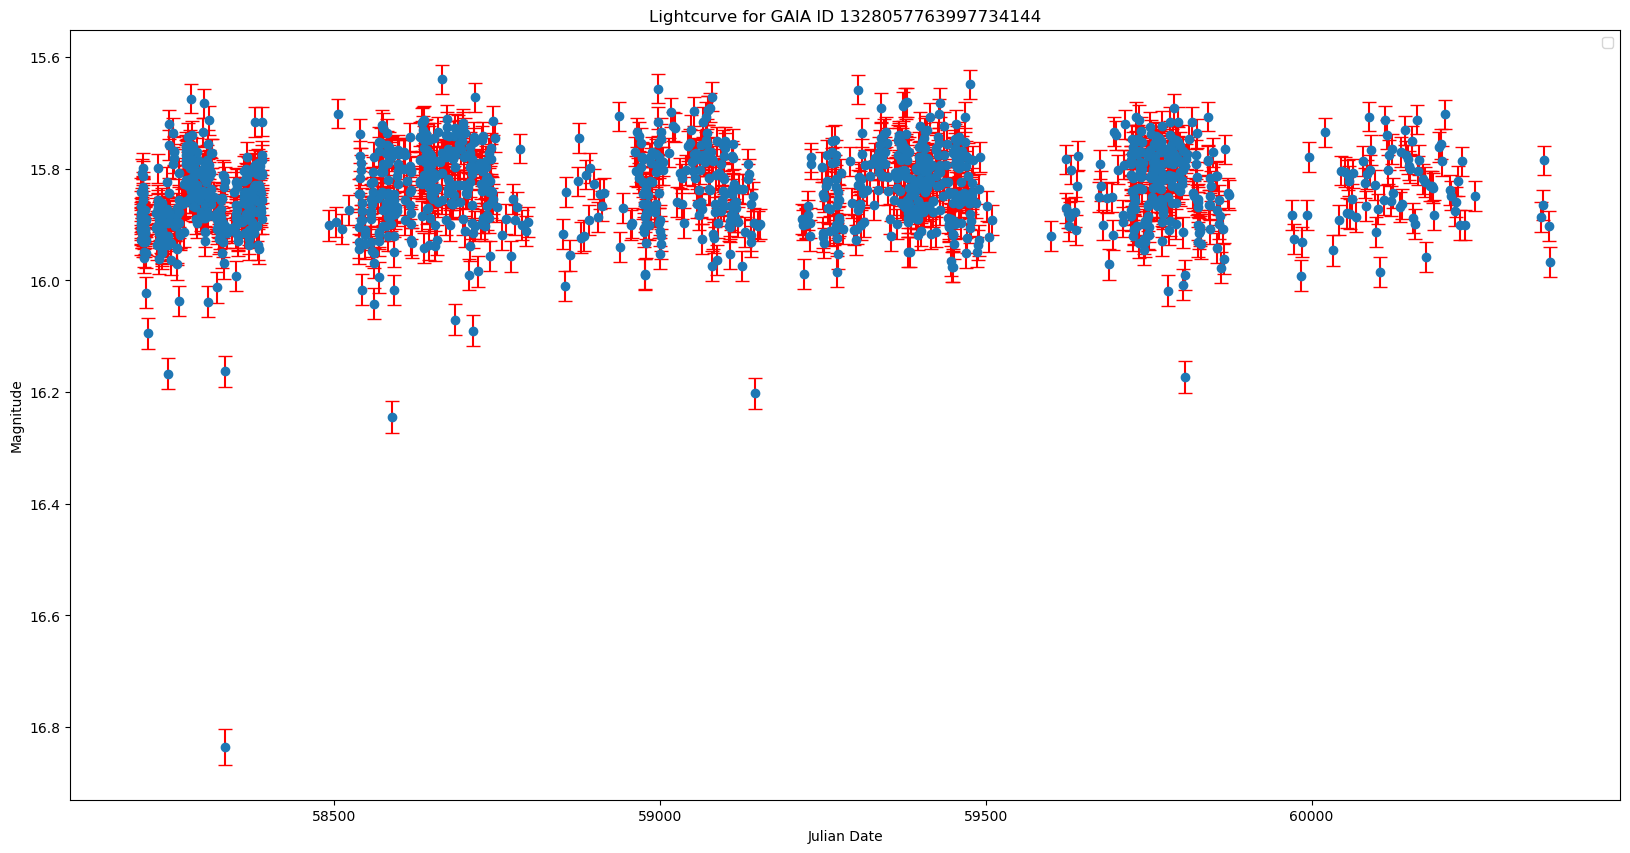

In [176]:
# Check if data is available
if not lc_data.empty:
    # Extract time (in JD) and magnitude from the data
    time = lc_data['mjd']
    magnitude = lc_data['mag']
    mag_err = lc_data['magerr']
    
    # Plot the lightcurve
    plt.figure(figsize=(20, 10))
    plt.errorbar(time, magnitude, yerr=mag_err, fmt='o', ls='None', ecolor='red', capsize=5)
    plt.xlabel('Julian Date')
    plt.ylabel('Magnitude')
    plt.title(f'Lightcurve for GAIA ID {gaia_id}')
    plt.gca().invert_yaxis()  # Magnitude scale is inverted
    plt.legend()
    plt.show()
else:
    print(f"No lightcurve data found for GAIA ID {gaia_id} in ZTF.")

In [154]:
lc_data.columns

Index(['oid', 'expid', 'hjd', 'mjd', 'mag', 'magerr', 'catflags', 'filtercode',
       'ra', 'dec', 'chi', 'sharp', 'filefracday', 'field', 'ccdid', 'qid',
       'limitmag', 'magzp', 'magzprms', 'clrcoeff', 'clrcounc', 'exptime',
       'airmass', 'programid'],
      dtype='object')

In [181]:
lc_data.oid

0       680115100004829
1       680115100004829
2       680115100004829
3       680115100004829
4       680115100004829
             ...       
1458    680115100004829
1459    680115100004829
1460    680115100004829
1461    680115100004829
1462    680115100004829
Name: oid, Length: 1463, dtype: int64

In [161]:
(time.max() - time.min())/365.3

5.9184015737749816

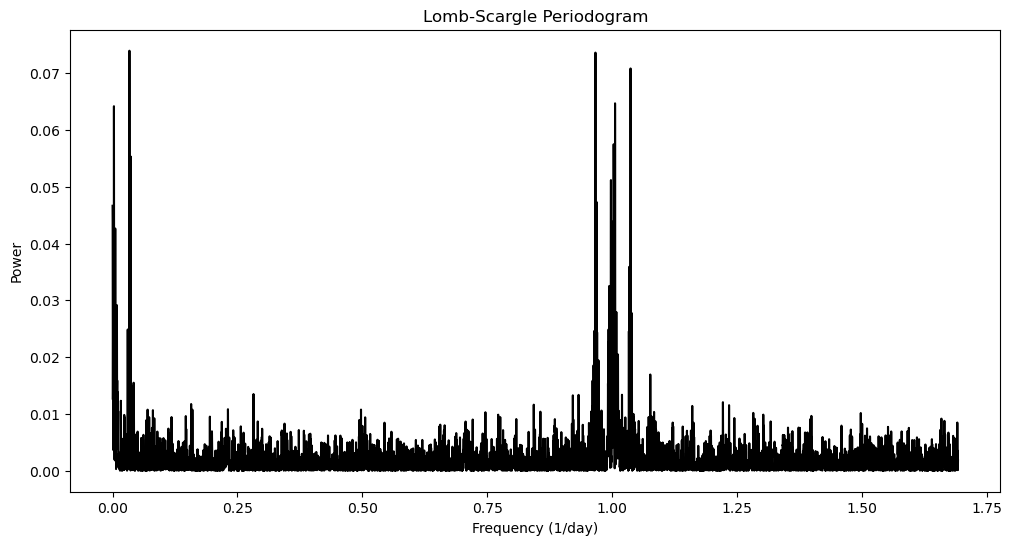

Best period: 29.575815251709997 days


In [179]:
from astropy.timeseries import LombScargle
import numpy as np

# Calculate the periodogram
frequency, power = LombScargle(time, magnitude).autopower()

# Plot the periodogram
plt.figure(figsize=(12, 6))
plt.plot(frequency, power, 'k-')
plt.xlabel('Frequency (1/day)')
plt.ylabel('Power')
plt.title('Lomb-Scargle Periodogram')
plt.show()

# Optionally, identify the best period
best_frequency = frequency[np.argmax(power)]
best_period = 1 / best_frequency
print(f'Best period: {best_period} days')

In [161]:
# gaia_id = '1827201859399292544'

In [163]:
from astroquery.gaia import Gaia

# # Replace with your actual GAIA ID
# gaia_id = '2061031492556083584'  # Example GAIA ID

# Query GAIA database for the star's variable flag
gaia_query = f"""
SELECT
    source_id,
    phot_variable_flag
FROM gaiadr3.gaia_source
WHERE source_id = {gaia_id}
"""

# Execute the query
job = Gaia.launch_job(gaia_query)
results = job.get_results()

# Check the phot_variable_flag
if len(results) > 0:
    phot_variable_flag = results['phot_variable_flag'][0]
    print(f"GAIA ID: {gaia_id}")
    print(f"Photometric Variable Flag: {phot_variable_flag}")
    
    # Interpret the flag
    if phot_variable_flag == 'VARIABLE':
        print("The star is classified as variable by GAIA.")
    elif phot_variable_flag == 'NOT_AVAILABLE':
        print("The variability information is not available for this star.")
    else:
        print("The star is not classified as variable by GAIA.")
else:
    print(f"No data found for GAIA ID {gaia_id}.")

GAIA ID: 3411572959360333312
Photometric Variable Flag: NOT_AVAILABLE
The variability information is not available for this star.


In [164]:
from astroquery.gaia import Gaia

# # Replace with your actual GAIA ID
# gaia_id = '2061031492556083584'  # Example GAIA ID

# Query GAIA database for the star's non_single_star flag
gaia_query = f"""
SELECT
    source_id,
    non_single_star
FROM gaiadr3.gaia_source
WHERE source_id = {gaia_id}
"""

# Execute the query
job = Gaia.launch_job(gaia_query)
results = job.get_results()

# Check the non_single_star flag
if len(results) > 0:
    non_single_star = results['non_single_star'][0]
    print(f"GAIA ID: {gaia_id}")
    print(f"Non-Single Star Flag: {non_single_star}")
    
    # Interpret the flag
    if non_single_star == 1:
        print("The star is classified as non-single (part of a multiple star system) by GAIA.")
    elif non_single_star == 0:
        print("The star is classified as single by GAIA.")
    else:
        print("The non-single star classification is not available for this star.")
else:
    print(f"No data found for GAIA ID {gaia_id}.")

GAIA ID: 3411572959360333312
Non-Single Star Flag: 0
The star is classified as single by GAIA.


In [165]:
results

SOURCE_ID,non_single_star
int64,int16
3411572959360333312,0


In [167]:
from astroquery.gaia import Gaia
from astroquery.mast import Catalogs
from astropy.coordinates import SkyCoord
import astropy.units as u

def gaia_to_tess(gaia_id, max_position_offset=0.15, max_magnitude_diff=2.0):
    # Step 1: Get Coordinates and Magnitude from GAIA DR3
    job = Gaia.launch_job(f"SELECT ra, dec, phot_g_mean_mag FROM gaiadr3.gaia_source WHERE source_id = {gaia_id}")
    gaia_results = job.get_results()
    if len(gaia_results) == 0:
        raise ValueError("GAIA source ID not found.")
    
    ra = gaia_results['ra'][0]
    dec = gaia_results['dec'][0]
    gaia_mag = gaia_results['phot_g_mean_mag'][0]
    
    # Create SkyCoord object
    coords = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
    
    # Step 2: Cross-match with TESS catalog
    tess_catalog = Catalogs.query_criteria(coordinates=coords, radius=0.002*u.deg, catalog='TIC', objType='STAR')
    
    # Check if we have results
    if len(tess_catalog) == 0:
        raise ValueError("No matching TESS ID found.")
    
    # Verify the closest match
    best_match = None
    for tess_entry in tess_catalog:
        tess_id = tess_entry['ID']
        tess_ra = tess_entry['ra']
        tess_dec = tess_entry['dec']
        tess_mag = tess_entry['Tmag']
        
        tess_coords = SkyCoord(ra=tess_ra*u.degree, dec=tess_dec*u.degree, frame='icrs')
        position_offset = coords.separation(tess_coords).arcsecond
        print(position_offset)
        
        magnitude_diff = abs(gaia_mag - tess_mag)
        
        if position_offset <= max_position_offset and magnitude_diff <= max_magnitude_diff:
            best_match = tess_id
            break
    
    if best_match is None:
        raise ValueError("No matching TESS ID found within the specified limits.")
    
    return best_match

# # Example usage
# gaia_id = '2061031492556083584'
try:
    tess_id = gaia_to_tess(gaia_id)
    print(f"GAIA ID {gaia_id} corresponds to TESS ID {tess_id}")
except ValueError as e:
    print(e)

0.03993426509177918
GAIA ID 3411572959360333312 corresponds to TESS ID 18684186


In [69]:
# from astroquery.gaia import Gaia
# import json

# # Load the final JSON file
# with open('color_natmag_cross11.json', 'r') as f:
#     final_data = json.load(f)

# # Open a text file to write B and V magnitudes with errors
# with open('GAIA_std.txt', 'w') as f:
#     # Write header
#     f.write("GAIA_ID\tBmag\tRmag\tGmag\tbp_rp\tepoch\tparallax\tazero_gspphot\tag_gspphot\tebpminrp_gspphot\n")

#     for gaia_id, plates_data in final_data.items():
#         # Get the GAIA ID
#         gaia_id_str = str(gaia_id)

#         # Query GAIA for the required magnitudes and other information
#         query = f"""
#         SELECT 
#             source_id, 
#             parallax,
#             ref_epoch,
#             phot_g_mean_mag,
#             phot_rp_mean_mag, 
#             phot_bp_mean_mag,
#             bp_rp, 
#             ag_gspphot,
#             azero_gspphot,
#             ebpminrp_gspphot
#         FROM gaiadr3.gaia_source 
#         WHERE source_id = {gaia_id_str}
#         AND phot_variable_flag = 'NOT_AVAILABLE';
#         """
#         job = Gaia.launch_job(query)
#         result = job.get_results()

#         if len(result) > 0:
#             # Extract the values
#             Bmag = result['phot_bp_mean_mag'][0]
#             Gmag = result['phot_g_mean_mag'][0]
#             Rmag = result['phot_rp_mean_mag'][0]
#             Bp_Rp = result['bp_rp'][0]
#             epoch = result['ref_epoch'][0]
#             parallax = result['parallax'][0]
#             ag_gspphot = result['ag_gspphot'][0]
#             azero_gspphot = result['azero_gspphot'][0]
#             ebpminrp_gspphot = result['ebpminrp_gspphot'][0]

#             # Write to file
#             f.write(f"{gaia_id_str}\t{Bmag:.3f}\t{Rmag:.3f}\t{Gmag:.3f}\t{Bp_Rp:.3f}\t{epoch}\t{parallax:.3f}\t{azero_gspphot:.3f}\t{ag_gspphot:.3f}\t{ebpminrp_gspphot:.3f}\n")
#         else:
#             # Skip writing if no data is found or if the star is not flagged as constant
#             continue

# print("B and V magnitudes saved to GAIA_std.txt")

## TESS Lightcurve

In [32]:
!pip install lightkurve

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/41.2 kB ? eta -:--:--
     ------------------ ------------------- 20.5/41.2 kB 640.0 kB/s eta 0:00:01
     -------------------------------------- 41.2/41.2 kB 499.5 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/265.9 kB ? eta -:--:--
   ---------------------------------------- 0.0/265.9 kB ? eta -:--:--
   ---------------------------------------- 0.0/265.9 kB ? eta -:--:--
   ------------------ --------------------- 122.9/265.9 kB ? eta -:--:--
   ------------------------ --------------- 163.8/265.9 kB 3.3 MB/s eta 0:00:01
   --------------------------------- ------ 225.3/265.9 kB 1.7 MB/s eta 0:00:01
   -------------

In [78]:
import lightkurve as lk
from lightkurve.correctors import CBVCorrector
from lightkurve.correctors import PLDCorrector
from lightkurve.correctors import RegressionCorrector
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import astropy.units as u
import sys
from sklearn.preprocessing import normalize

In [206]:
TIC = 'TIC 175232591'

In [208]:
# import pandas as pd
# pd.set_option('display.max_columns', None)
lk.search_lightcurve(TIC, mission="TESS")

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 44,2021,QLP,600,175232591,0.0
1,TESS Sector 45,2021,QLP,600,175232591,0.0
2,TESS Sector 46,2021,QLP,600,175232591,0.0


In [258]:
lc_collection = lk.search_lightcurve(TIC, author='QLP', mission="TESS", sector=[44, 45, 46]).download_all()

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

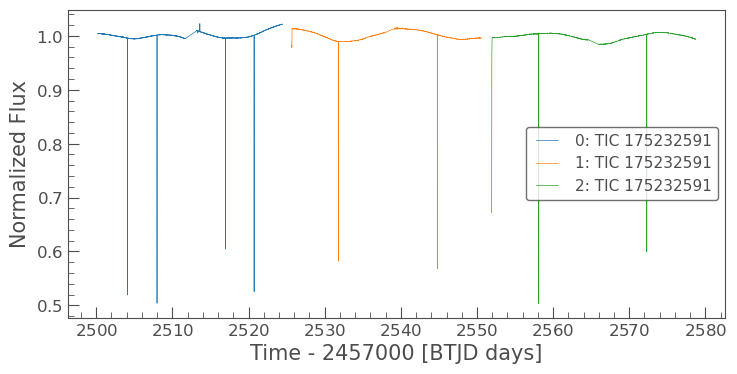

In [260]:
lc_collection.plot()

In [214]:
# search_result = lk.search_tesscut(TIC, sector=[44, 45, 46])

In [223]:
# tpf = search_result.download()

In [235]:
# tpf.plot()

In [227]:
# tpf.create_threshold_mask(threshold=0.25)

In [ ]:
# # Create a simple thresholded aperture mask
# aper = tpf.create_threshold_mask(threshold=0.25)

In [ ]:
# tpf.plot(aperture_mask = aper)

In [ ]:
# # Generate a simple aperture photometry light curve
# raw_lc = tpf.to_lightcurve(aperture_mask=aper)

In [136]:
# # # Create a design matrix using PCA components from the cutout background
# dm = lk.DesignMatrix(tpf.flux[:, ~aper], name='pixel regressors').append_constant()

In [138]:
# pld = PLDCorrector(tpf)

In [140]:
# pld_lc = pld.correct()

In [245]:
# Generate the CBVCorrector object and interpolate the downloaded CBVs to the light curve cadence
cbvcorrector = lk.CBVCorrector(lc_collection.flux, interpolate_cbvs=True, extrapolate_cbvs=True)

Exception: <lc> must be a LightCurve class

In [142]:
cbvcorrector.cbvs

[TESS CBVs, Sector.Camera.CCD : 57.1.1, CBVType : SingleScale, nCBVS : 16,
 TESS CBVs, Sector.Camera.CCD : 57.1.1, CBVType.Band: MultiScale.1, nCBVs : 8,
 TESS CBVs, Sector.Camera.CCD : 57.1.1, CBVType.Band: MultiScale.2, nCBVs : 8,
 TESS CBVs, Sector.Camera.CCD : 57.1.1, CBVType.Band: MultiScale.3, nCBVs : 2,
 TESS CBVs, Sector.Camera.CCD : 57.1.1, CBVType : Spike, nCBVS : 6]

<Axes: title={'center': 'TESS CBVs (Sector.Camera.CCD : 57.1.1, CBVType : SingleScale)'}, xlabel='Time [btjd]'>

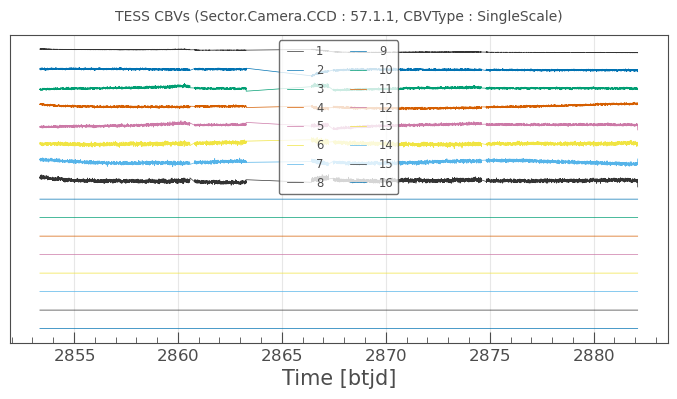

In [144]:
cbvcorrector.cbvs[0].plot()

Over-fitting metric: 0.039337310825460985
Under fitting metric: 0.9941190751815
CDPP: 309.2462960002008 ppm


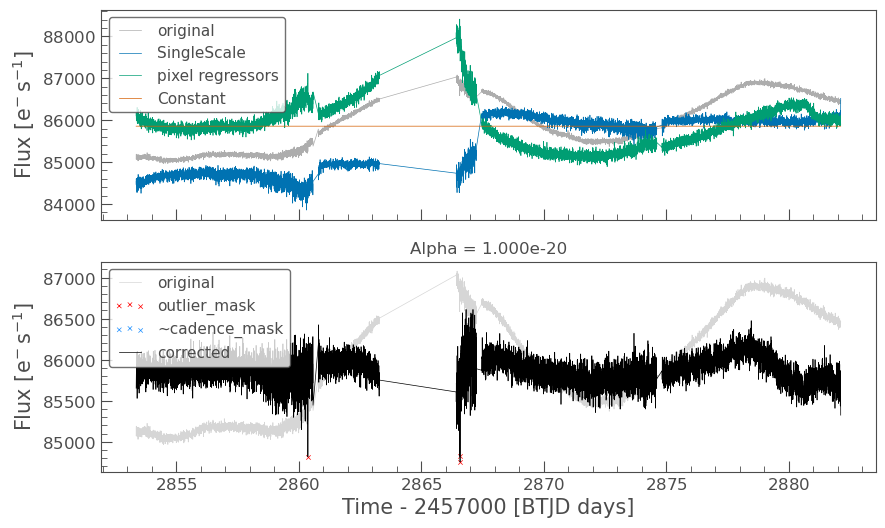

In [150]:
# Perform an unrestricted least-squares fit using only the pixel-derived design matrix.
cbvcorrector.correct_gaussian_prior(ext_dm=dm)
cbvcorrector.diagnose()
print('Over-fitting metric: {}'.format(cbvcorrector.over_fitting_metric()))
print('Under fitting metric: {}'.format(cbvcorrector.under_fitting_metric()))
print('CDPP: {}'.format(cbvcorrector.corrected_lc.estimate_cdpp()))
corrected_lc_just_pixel_dm = cbvcorrector.corrected_lc

In [151]:
print(dm.df.shape)
print(len(raw_lc.flux))

(10791, 14)
10791


Over fitting metric: 0.00371282150060091
Under fitting metric: 0.9924759531682568
CDPP: 477.79908196729394 ppm


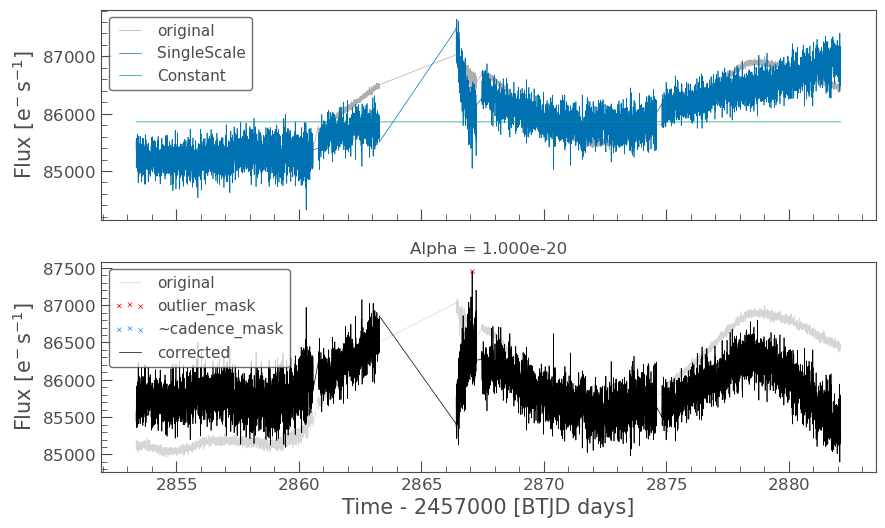

In [152]:
cbv_type = ['MultiScale.1', 'MultiScale.2', 'MultiScale.3', 'Spike']
cbv_indices = [np.arange(1,9), np.arange(1,9), np.arange(1,9), 'ALL']
cbvcorrector.correct_gaussian_prior() # cbv_type=cbv_type, cbv_indices=cbv_indices, ext_dm=dm, alpha=1e-4
cbvcorrector.diagnose()
print('Over fitting metric: {}'.format(cbvcorrector.over_fitting_metric()))
print('Under fitting metric: {}'.format(cbvcorrector.under_fitting_metric()))
print('CDPP: {}'.format(cbvcorrector.corrected_lc.estimate_cdpp()))
corrected_lc_joint_fit = cbvcorrector.corrected_lc

Optimized Over-fitting metric: 0.8379956282130251
Optimized Under-fitting metric: 0.9976284628447034
Optimized Alpha: 8.554e-03
CDPP: 112.83081314482344 ppm


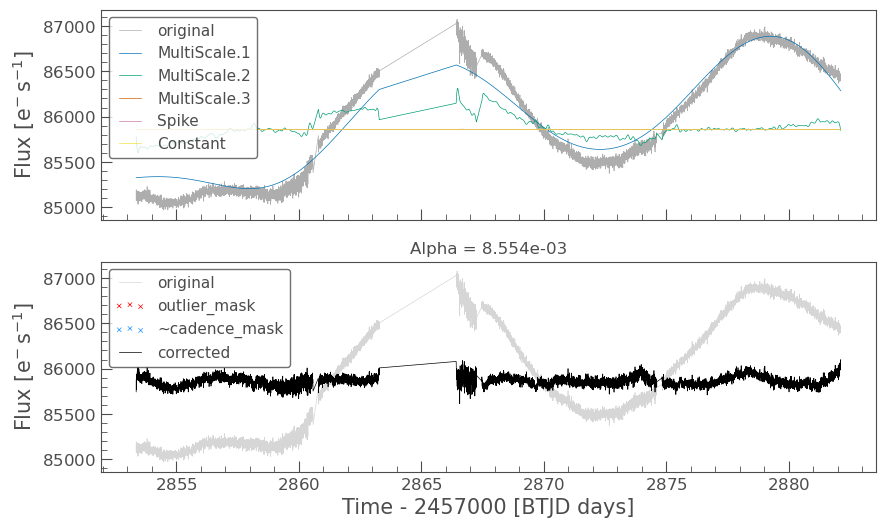

In [153]:
# Optimize the fit but ignore the under-fitting metric and set bounds on the alpha parameter.
cbvcorrector.correct(cbv_type=cbv_type, cbv_indices=cbv_indices, alpha_bounds=[1e-6, 1e-2], target_over_score=0.9, target_under_score=0.5)
cbvcorrector.diagnose()
print('CDPP: {}'.format(cbvcorrector.corrected_lc.estimate_cdpp()))

Text(0.5, 1.0, 'Comparison Between original and final corrected lightcurve')

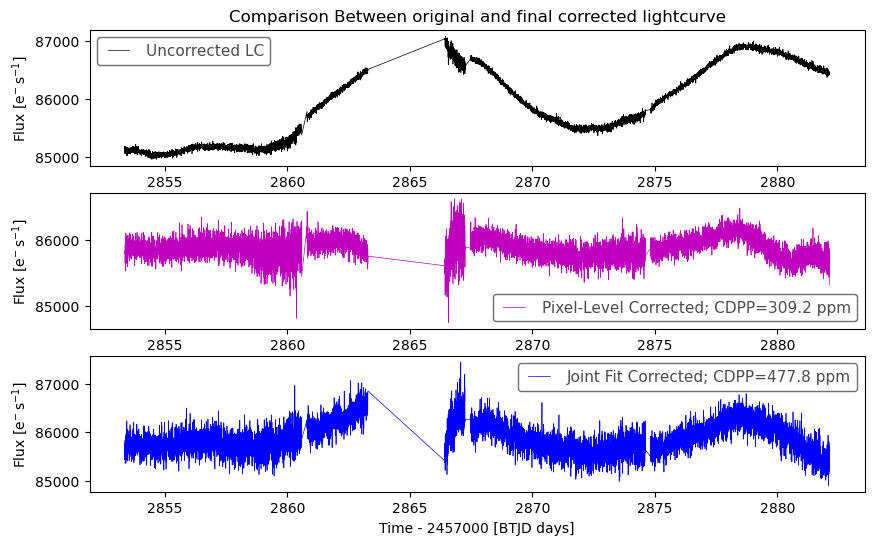

In [154]:
_, ax = plt.subplots(3, figsize=(10, 6))
cbvcorrector.lc.plot(ax=ax[0], normalize=False, label='Uncorrected LC', c='k')
corrected_lc_just_pixel_dm.plot(normalize=False, label='Pixel-Level Corrected; CDPP={0:.1f}'.format(corrected_lc_just_pixel_dm.estimate_cdpp()), ax=ax[1], c='m')
corrected_lc_joint_fit.plot(normalize=False, label='Joint Fit Corrected; CDPP={0:.1f}'.format(corrected_lc_joint_fit.estimate_cdpp()), ax=ax[2], c='b')
ax[0].set_title('Comparison Between original and final corrected lightcurve')

In [155]:
# # Convert flux to magnitude
# # Reference flux can be taken as the median flux value or another reference point
# reference_flux = np.median(corrected_lc_joint_fit.flux)

# # Calculate magnitude
# magnitude = -2.5 * np.log10(corrected_lc_joint_fit.flux / reference_flux)

# # Create a new LightCurve object with the magnitude values
# mag_lc = lk.LightCurve(time=corrected_lc_joint_fit.time, flux=magnitude)

# # Plot the result
# mag_lc.plot(label="Magnitude")
# plt.ylabel("Magnitude")
# plt.show()

In [162]:
pg = corrected_lc_joint_fit.to_periodogram(oversample_factor=1)

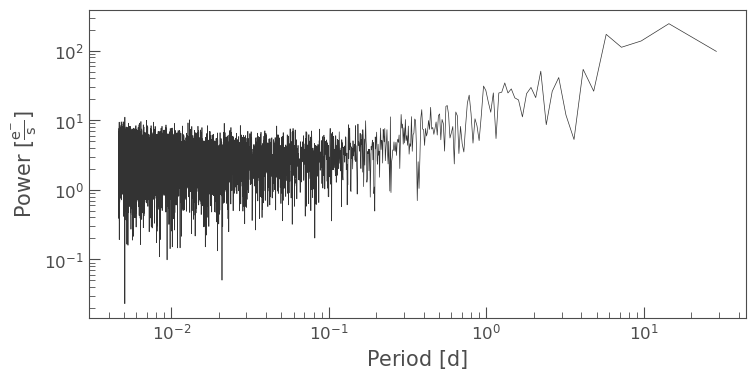

In [164]:
pg.plot(view='period', scale='log');

In [166]:
pg.period

<Quantity [2.87571650e+01, 1.43785825e+01, 9.58572168e+00, ...,
           4.63152924e-03, 4.63078342e-03, 4.63003784e-03] d>

In [168]:
2*pg.power

<Quantity [195.79078666, 490.05078288, 276.31915813, ...,   3.82621619,
             3.95561123,   6.40096328] electron / s>

In [170]:
pg.period_at_max_power

<Quantity 14.37858252 d>

In [172]:
lc = corrected_lc_joint_fit

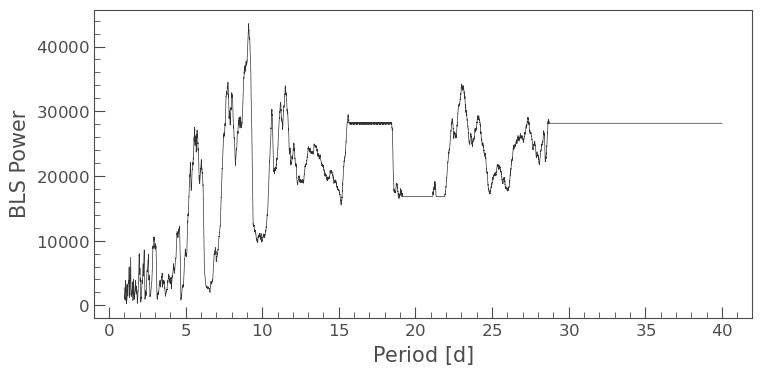

In [176]:
import numpy as np
# Create array of periods to search
period = np.linspace(1, 40, 10000)
# Create a BLSPeriodogram
bls = corrected_lc_joint_fit.to_periodogram(method='bls', period=period, frequency_factor=500);
bls.plot();

In [ ]:
planet_b_period = bls.period_at_max_power
planet_b_t0 = bls.transit_time_at_max_power
planet_b_dur = bls.duration_at_max_power

# Check the value for period
planet_b_period

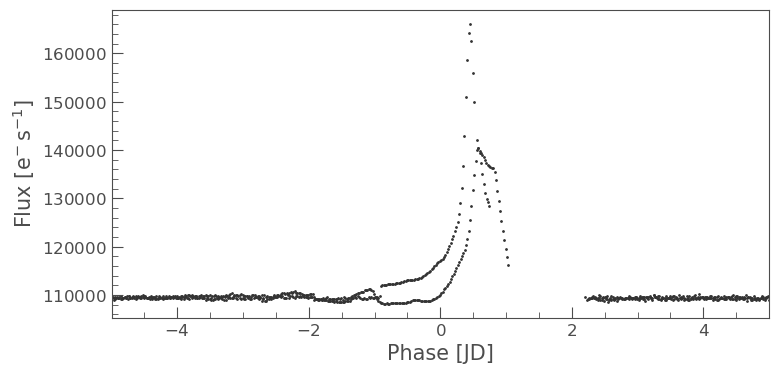

In [747]:
ax = lc.fold(period=planet_b_period, epoch_time=planet_b_t0).scatter()
ax.set_xlim(-5, 5);

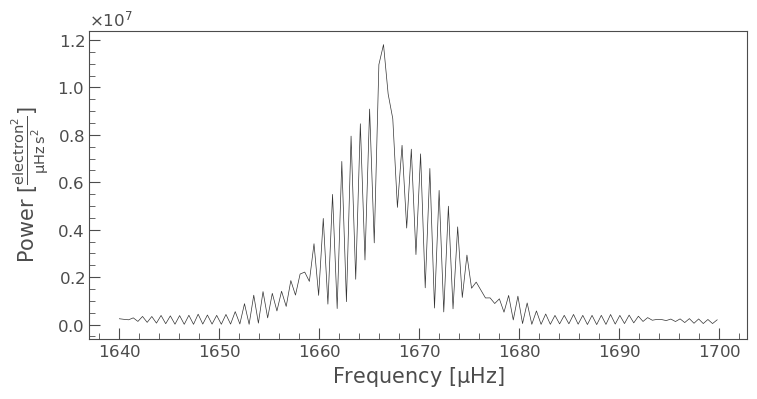

In [648]:
pg = lc.to_periodogram(normalization='psd',
                       minimum_frequency=1640,
                       maximum_frequency=1700)
ax = pg.plot();

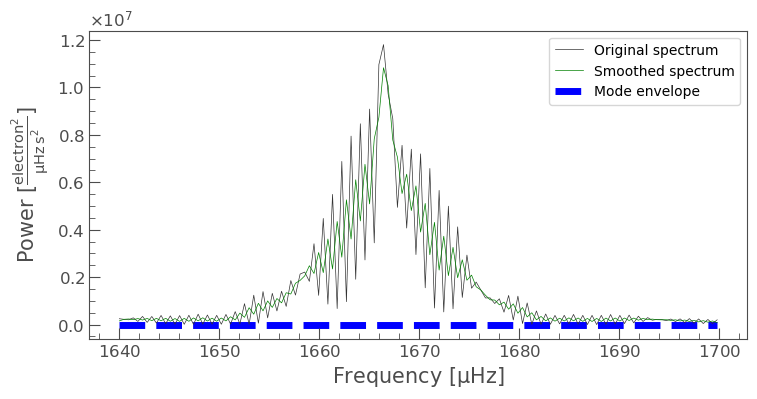

In [649]:
# Plot a smoothed version of the power spectrum on top in green
ax = pg.plot(label='Original spectrum')
pg.smooth(filter_width=1).plot(ax=ax,
                               color='green',
                               label='Smoothed spectrum')

# Highlight the "mode envelope" using a Gaussian curve
f = pg.frequency.value
ax.plot(f, 5e-11*np.exp(-(f-1670)**2/(2*17.34**2)),
        lw=5, ls='--', zorder=0,
        color='blue', label='Mode envelope');

# Annotate the modes using red arrows
for i in range(6):
  ax.annotate('',
              xy=(1831.66+i*103.8, 5.2e-11),
              xytext=(1831.66+i*103.8, 7e-11),
              arrowprops=dict(arrowstyle='->',
              color='red',
              linewidth=1.5))
ax.legend();

In [650]:
np.std(f)

17.387800735326977

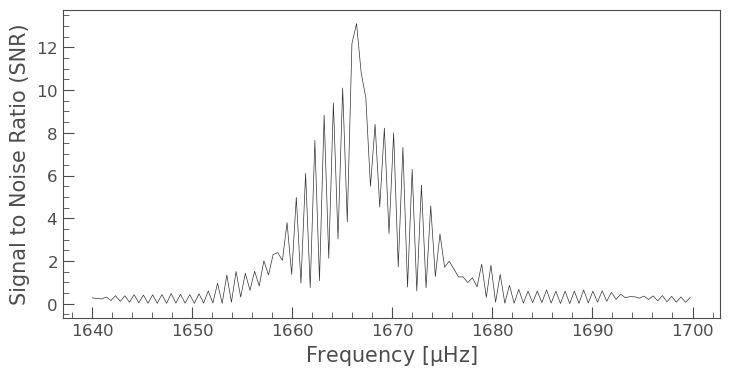

In [651]:
snr = pg.flatten()
ax = snr.plot();

In [227]:
seismology = snr.to_seismology()

In [229]:
seismology = snr.to_seismology()

In [291]:
seismology.numax.value

AttributeError: 'Seismology' object has no attribute 'numax'